In [1]:
using_colab = True

if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
import skimage

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-62lj2n_x
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-62lj2n_x
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=eb352f9c0c1148b86f3caf3d2b705d86837d1a1ea54766a1f47a4c614928a798
  Stored in directory: /tmp/pip-ephem-wheel-cache-s3yhoz7a/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-08-10 18:04:24--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.224.2.6, 13.224.2.88, 13.22

In [2]:
#visualization functions
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=300):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='yellow', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='yellow', facecolor=(0,0,0,0), lw=3))


In [3]:
#First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint.
#Running on CUDA and using the default model are recommended for best results.
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

#Points or bounding boxes as inputs to SAM

In [4]:
#load an image example from url, its ground truth mask and QuPath annotations at the WSI level
!mkdir example
!wget -P example https://raw.githubusercontent.com/bertrandchauveau/FromQuPathToSAM/7aec6683093947f60eb04dd8a10c006b5a837979/example/TM_renal_biopsy_%5Bd%3D2%2Cx%3D79872%2Cy%3D35840%2Cw%3D2048%2Ch%3D2048%5D.jpg
!wget -P example https://raw.githubusercontent.com/bertrandchauveau/FromQuPathToSAM/7aec6683093947f60eb04dd8a10c006b5a837979/example/TM_renal_biopsy_%5Bd%3D2%2Cx%3D79872%2Cy%3D35840%2Cw%3D2048%2Ch%3D2048%5D.png
!wget -P example https://raw.githubusercontent.com/bertrandchauveau/FromQuPathToSAM/2cd06f1dd46aaba7345ed485fcec4e9c15a4c2eb/example/TM_renal_biopsy-points.tsv

--2023-08-10 18:05:13--  https://raw.githubusercontent.com/bertrandchauveau/FromQuPathToSAM/7aec6683093947f60eb04dd8a10c006b5a837979/example/TM_renal_biopsy_%5Bd%3D2%2Cx%3D79872%2Cy%3D35840%2Cw%3D2048%2Ch%3D2048%5D.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283631 (277K) [image/jpeg]
Saving to: ‘example/TM_renal_biopsy_[d=2,x=79872,y=35840,w=2048,h=2048].jpg’

TM_renal_biopsy_[d= 100%[===================>] 276.98K  --.-KB/s    in 0.02s   

2023-08-10 18:05:13 (12.5 MB/s) - ‘example/TM_renal_biopsy_[d=2,x=79872,y=35840,w=2048,h=2048].jpg’ saved [283631/283631]

--2023-08-10 18:05:13--  https://raw.githubusercontent.com/bertrandchauveau/FromQuPathToSAM/7aec6683093947f60eb04dd8a10c006b5a837979/example/TM_renal_biopsy_%5Bd%3D2%2Cx%3D79872%2Cy%3D35840%2C

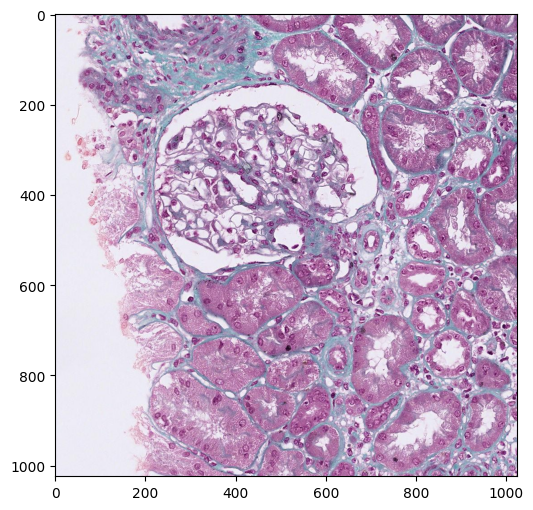

In [5]:
#display image
path_env = '/content/example/'
img_size = (1024,1024)

image = cv2.imread(path_env + 'TM_renal_biopsy_[d=2,x=79872,y=35840,w=2048,h=2048].jpg')
image = cv2.resize(image, img_size, interpolation = cv2.INTER_LINEAR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis('on')
plt.show()

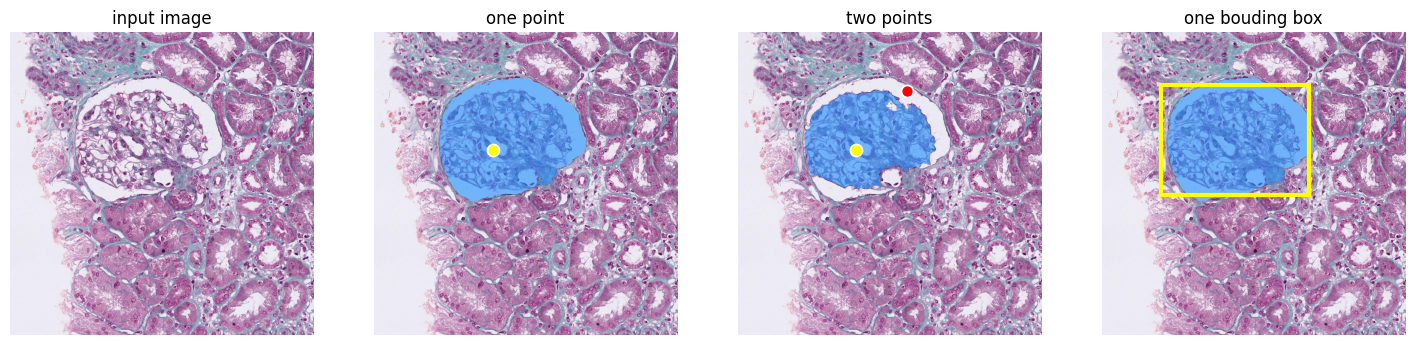

In [6]:
#Image embedding by SAM
predictor.set_image(image)  # around 2.5 minutes on CPU, a few seconds with GPU

#One foreground point as input to segment the glomerulus
input_point1 = np.array([[400, 400]])  #shape (1,2), one point [x,y]
input_label1 = np.array([1])   #0 background, 1 foreground.

#one foreground point and one background as inputs to segment the glomerular tuft
input_point2 = np.array([[400, 400], [570, 200]])
input_label2 = np.array([1, 0])

#one bounding box as input to segment the glomerulus
input_box = np.array([200, 180, 700, 550])   #shape (4,)  [x,y,x,y]

#one point: prediction
masks1, _, _ = predictor.predict(
    point_coords=input_point1,
    point_labels=input_label1,
    multimask_output=False,   #one mask output
)

#two points: prediction
masks2, _, _ = predictor.predict(
    point_coords=input_point2,
    point_labels=input_label2,
    multimask_output=False,  #one mask output
)

#one bbox: prediction
masks3, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],  #bbox shape (1,4)
    multimask_output=False,
)

#plot figures
plt.figure(figsize=(18,18))
plt.subplot(1,4,1)
plt.imshow(image)
plt.axis("off")
plt.title("input image")

plt.subplot(1,4,2)
plt.imshow(image)
show_mask(masks1, plt.gca())
show_points(input_point1, input_label1, plt.gca())
plt.axis('off')
plt.title("one point")

plt.subplot(1,4,3)
plt.imshow(image)
show_mask(masks2, plt.gca())
show_points(input_point2, input_label2, plt.gca())
plt.axis('off')
plt.title("two points")

plt.subplot(1,4,4)
plt.imshow(image)
show_mask(masks3[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.title("one bouding box");

#Autogeneration of masks

In [7]:
#visualization function
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

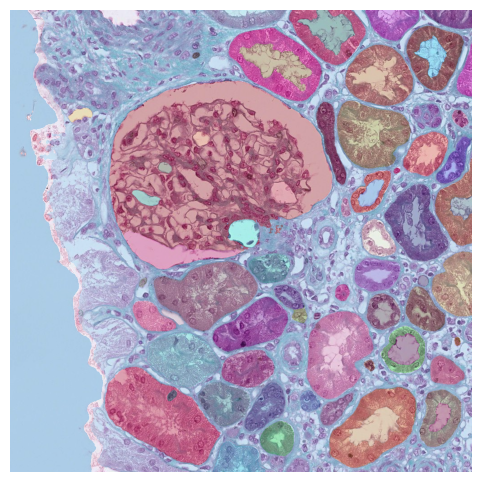

In [8]:
#autogenerated masks by SAM
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=16)
masks = mask_generator.generate(image) #around 4 minutes on CPU, a few seconds on GPU

plt.figure(figsize=(6,6))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

# SAM-aided segmentation from QuPath annotations

In [9]:
#collect point annotations from QuPath at the WSI level
#in this example, each object is highlighted by only one foreground point
path_env = '/content/example/'
tile_name = 'TM_renal_biopsy_[d=2,x=79872,y=35840,w=2048,h=2048].jpg'
points_df = pd.read_csv(path_env+ 'TM_renal_biopsy-points.tsv', sep="\t")

def prepare_SAM(tile_name, tile_points_df, class_name): #identifies WSI annotations that are within the tile and converts absolute coordinates to relative (WSI=> tiles) depending on class
    #selecting class and df to numpy conversion
    points_class_df = tile_points_df[tile_points_df["class"] == class_name]
    points_class_array = points_class_df[["x","y"]].values

    #collecting coordinates of the tile and the downscaling factor from the name of the tile
    tile_x = float(tile_name.split('x=')[1].split(',')[0])
    tile_y = float(tile_name.split('y=')[1].split(',')[0])
    tile_w = float(tile_name.split('w=')[1].split(',')[0])
    tile_h = float(tile_name.split('h=')[1].split(']')[0])
    downsample = float(tile_name.split('[d=')[1].split(',')[0])

    #identifying WSI annotations that are within the tile
    points_class_array_filter_x = points_class_array[(points_class_array[:,0] >= tile_x) * (points_class_array[:,0] <= (tile_x+tile_w))]
    points_class_array_filter_xy = points_class_array_filter_x[(points_class_array_filter_x[:,1] >= tile_y) * (points_class_array_filter_x[:,1] <= (tile_y+tile_h))]
    #convert to relative coordinates
    input_points_x = (points_class_array_filter_xy[:,0] - np.ones(len(points_class_array_filter_xy)) * tile_x) /downsample
    input_points_y = (points_class_array_filter_xy[:,1] - np.ones(len(points_class_array_filter_xy)) * tile_y) /downsample
    input_points = np.stack((input_points_x, input_points_y), axis=-1)
    input_labels = np.ones(len(input_points))  #1 = foreground points
    return input_points, input_labels

#visualization functions
def show_points2(coords, labels, ax, marker_size=300, color='green'):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color=color, marker='.', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)

green = np.array([0/255, 255/255, 0/255, 0.6])
blue = np.array([0/255, 0/255, 255/255, 0.6])
red = np.array([255/255, 0/255, 0/255, 0.6])
def show_mask2(mask, ax, color=green):
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def process_SAM(input_points, input_labels, image):
    input_points = torch.tensor(np.expand_dims(input_points, axis=1), device=predictor.device)  # here will be shape (Batch,1,2) : batch, 1 point, 2 coordinates xy
    input_labels = torch.tensor(np.expand_dims(input_labels, axis=-1), device=predictor.device)  # shape (Batch,1) : batch, 1 label (here only one point per object)
    transformed_points = predictor.transform.apply_coords_torch(input_points, image.shape[:2])
    masks, _, _ = predictor.predict_torch(
        point_coords=transformed_points,
        point_labels=input_labels,
        boxes=None,
        multimask_output=False,
    )
    return masks

In [10]:
#collect all points per class for the considered tile and perform the predictions by SAM
if points_df["class"].value_counts()['Tubule'] > 0:  #WSI level
    input_points_Tub, input_labels_Tub = prepare_SAM(tile_name, points_df, class_name='Tubule')
    if np.any(input_points_Tub) == True:  #tile level
        masks_Tub = process_SAM(input_points_Tub, input_labels_Tub, image)

if points_df["class"].value_counts()['Glomerulus'] > 0:   #WSI level
    input_points_Glom, input_labels_Glom = prepare_SAM(tile_name, points_df, class_name='Glomerulus')
    if np.any(input_points_Glom) == True:  #tile level
        masks_Glom = process_SAM(input_points_Glom, input_labels_Glom, image)

if points_df["class"].value_counts()['Vessel'] > 0:   #WSI level
    input_points_Ves, input_labels_Ves = prepare_SAM(tile_name, points_df, class_name='Vessel')
    if np.any(input_points_Ves) == True:  #tile level
        masks_Ves = process_SAM(input_points_Ves, input_labels_Ves, image)

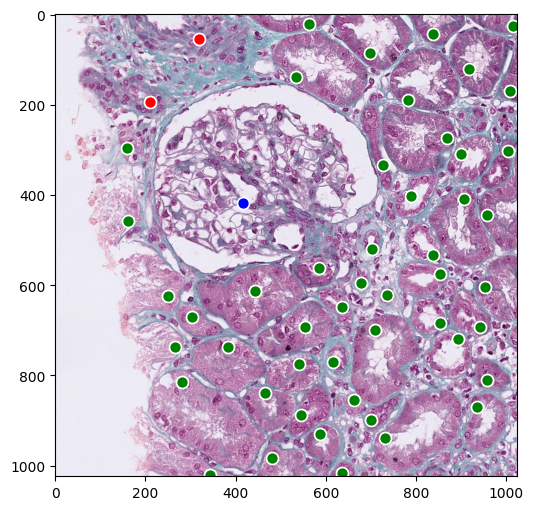

In [11]:
#visualization of all point inputs
plt.figure(figsize=(6,6))
plt.imshow(image)
show_points2(input_points_Glom, input_labels_Glom, plt.gca(), color='blue')
show_points2(input_points_Tub, input_labels_Tub, plt.gca(), color='green')
show_points2(input_points_Ves, input_labels_Ves, plt.gca(), color='red')
plt.axis('on')
plt.show()

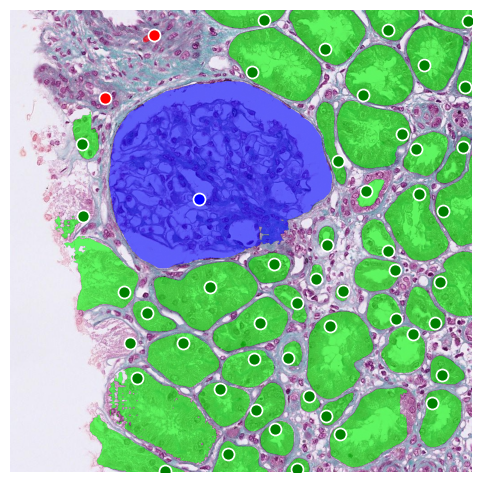

In [12]:
#plot of all predictions, with a minimal post-processing step
plt.figure(figsize=(6, 6))
plt.imshow(image)
for mask in masks_Tub:
    mask_array = mask.cpu().numpy()
    if np.mean(mask_array) <= 0.10:  #ignore if a predicted tubule encompasses >10% of the image
        show_mask2(mask.cpu().numpy(), plt.gca(), color=green)
for mask in masks_Glom:
    mask_array = mask.cpu().numpy()
    if np.mean(mask_array) <= 0.30:  #ignore if a predicted glomerulus encompasses >30% of the image
        show_mask2(mask.cpu().numpy(), plt.gca(), color=blue)
for mask in masks_Ves:
    mask_array = mask.cpu().numpy()
    if np.mean(mask_array) <= 0.10:  #ignore if a predicted vessel encompasses >10% of the image
        show_mask2(mask.cpu().numpy(), plt.gca(), color=red)
if np.any(input_points_Glom) == True:
    show_points2(input_points_Glom, input_labels_Glom, plt.gca(), color='blue')
if np.any(input_points_Tub) == True:
    show_points2(input_points_Tub, input_labels_Tub, plt.gca(), color='green')
if np.any(input_points_Ves) == True:
    show_points2(input_points_Ves, input_labels_Ves, plt.gca(), color='red')
plt.axis('off')
plt.show()

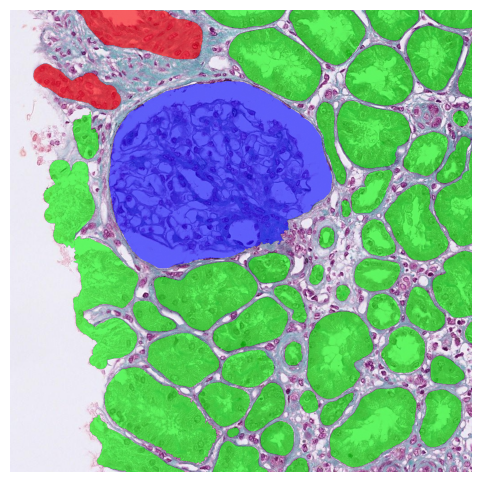

In [13]:
#ground truth image
#load ground truth mask
img_size = (1024,1024)   #same dimension as export from QuPath
truth_mask = cv2.imread(path_env+ 'TM_renal_biopsy_[d=2,x=79872,y=35840,w=2048,h=2048].png', 0)   #,0 = grayscale mode
truth_mask  = cv2.resize(truth_mask, img_size, interpolation = cv2.INTER_NEAREST )
truth_mask[truth_mask == 45] = 1
truth_mask[truth_mask == 50] = 2
truth_mask[truth_mask == 191] = 3   #convert values from QuPath to series:  0,45,50,191 => 0,1,2,3 (three classes here, glomerulus, tubule and vessel)

def onehottify(x, n=None, dtype=float):  #one_hot encoding
    x = np.asarray(x)
    n = np.max(x) + 1 if n is None else n
    return np.eye(n, dtype=dtype)[x]

#truth_mask one_hot encoding
truth_mask_onehot = onehottify(truth_mask)

color_red = np.array([255/255, 0/255, 0/255, 0.6])
color_blue = np.array([0/255, 0/255, 255/255, 0.6])
color_green= np.array([0/255, 255/255, 0/255, 0.6])
#vessel
h, w = truth_mask_onehot[:,:,1].shape  #1 = vessel
mask_image_ves = truth_mask_onehot[:,:,1].reshape(h, w, 1) * color_red.reshape(1, 1, -1)
#tubule
h, w = truth_mask_onehot[:,:,2].shape  #2 = tubule
mask_image_tub = truth_mask_onehot[:,:,2].reshape(h, w, 1) * color_green.reshape(1, 1, -1)
#glomerulus
h, w = truth_mask_onehot[:,:,3].shape  #3 = glomerulus
mask_image_glom = truth_mask_onehot[:,:,3].reshape(h, w, 1) * color_blue.reshape(1, 1, -1)

#plot figure
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.imshow(mask_image_tub)
plt.imshow(mask_image_ves)
plt.imshow(mask_image_glom)
plt.axis('off')
plt.show()